In [ ]:
#pip install gym[classic_control]

In [ ]:
from sklearn.preprocessing import KBinsDiscretizer
import numpy as np
import time, math, random
from typing import Tuple

# import gym
import gym

In [ ]:
env = gym.make('CartPole-v1')

In [ ]:
g = 9.8
mk = 1.0
mp = 0.1
lp = 0.5
mt = mp + mk

In [ ]:
# state matrix
a = g/(lp*(4.0/3 - mp/(mp+mk)))
A = np.array([[0, 1, 0, 0],
              [0, 0, a, 0],
              [0, 0, 0, 1],
              [0, 0, a, 0]])

# input matrix
b = -1/(lp*(4.0/3 - mp/(mp+mk)))
B = np.array([[0], [1/mt], [0], [b]])

In [ ]:
R = np.eye(1, dtype=int)          # choose R (weight for input)
Q = 5*np.eye(4, dtype=int)        # choose Q (weight for state)

# get riccati solver
from scipy import linalg

# solve ricatti equation
P = linalg.solve_continuous_are(A, B, Q, R)

# calculate optimal controller gain
K = np.dot(np.linalg.inv(R),
           np.dot(B.T, P))

In [ ]:
def apply_state_controller(K, x):
    # feedback controller
    u = -np.dot(K, x)   # u = -Kx
    if u > 0:
        return 1, u     # if force_dem > 0 -> move cart right
    else:
        return 0, u     # if force_dem <= 0 -> move cart left

In [ ]:
# import os
# os.environ["SDL_VIDEODRIVER"] = "dummy"
# import pygame
# pygame.display.set_mode((640,480))

In [ ]:
# get environment
env = gym.make('CartPole-v1')
env.env.seed(1)     # seed for reproducibility
obs = env.reset()

arr1 = []
arr2 = []
for i in range(1000):
    if i>990:
      print('hwllo')
    #env.render()

    # get force direction (action) and force value (force)
    action, force = apply_state_controller(K, obs)

    # absolute value, since 'action' determines the sign, F_min = -10N, F_max = 10N
    abs_force = abs(float(np.clip(force, -10, 10)))

    # change magnitute of the applied force in CartPole
    env.env.force_mag = abs_force

    # apply action
    obs, reward, done, _ = env.step(action)
    arr1.append(obs[2])
    arr2.append(i)
    if done:
        print(f'Terminated after {i+1} iterations.')
        break

env.close()

Terminated after 500 iterations.


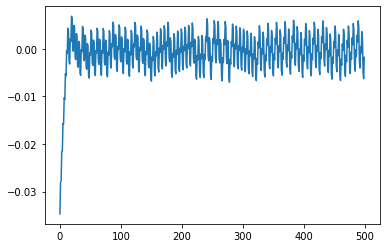

In [ ]:
import matplotlib.pyplot as plt
plt.plot(arr2,arr1)

In [ ]:
import gym
import numpy as np
import random
import math
from time import sleep

## Result: https://gym.openai.com/evaluations/eval_QykiR71DR0mpXEXslkpDLQ

## Initialize the "Cart-Pole" environment
env = gym.make('CartPole-v0')

## Defining the environment related constants

# Number of discrete states (bucket) per state dimension
NUM_BUCKETS = (1, 1, 6, 3)  # (x, x', theta, theta')
# Number of discrete actions
# NUM_ACTIONS = env.action_space.n # (left, right)
NUM_ACTIONS = 5 # (left, right)
# Bounds for each discrete state
STATE_BOUNDS = list(zip(env.observation_space.low, env.observation_space.high))
# Manually setting bounds (needed for the x_dot and theta_dot)
#STATE_BOUNDS[0] = [STATE_BOUNDS[0][0]/2, STATE_BOUNDS[0][1]/2]
STATE_BOUNDS[1] = [-0.5, 0.5]
#STATE_BOUNDS[2] = [STATE_BOUNDS[2][0]/2, STATE_BOUNDS[2][0]/2]
STATE_BOUNDS[3] = [-math.radians(50), math.radians(50)]

## Creating a Q-Table for each state-action pair
q_table = np.zeros(NUM_BUCKETS + (NUM_ACTIONS,))

## Learning related constants
MIN_EXPLORE_RATE = 0.01
MIN_LEARNING_RATE = 0.2

# Defining the simulation related constants
NUM_EPISODES = 1000
MAX_T = 250
STREAK_TO_END = 120
SOLVED_T = 199
DEBUG_MODE = False
ENABLE_UPLOAD = False


if ENABLE_UPLOAD:
    env.monitor.start('/tmp/cart_pole_q_learning_4D', force=True)


def simulate():

    ## Instantiating the learning related parameters
    learning_rate = get_learning_rate(0)
    explore_rate = get_explore_rate(0)
    discount_factor = 0.999  # since the world is unchanging

    num_streaks = 0


    for episode in range(NUM_EPISODES):

        # Reset the environment
        obv = env.reset()

        # the initial state
        state_0 = state_to_bucket(obv)

        for t in range(MAX_T):
            # env.render()

            # Select an action
            action = select_action(state_0, explore_rate)

            # Execute the action
            actionArr = [[0,10],[1,10],[0,5],[1,5],[0,0]]

            temp = env.force_mag
            env.force_mag = actionArr[action][1]
            obv, reward, done, _ = env.step(actionArr[action][0])
            env.force_mag = temp

            # Observe the result
            state = state_to_bucket(obv)

            # Update the Q based on the result
            best_q = np.amax(q_table[state])
            q_table[state_0 + (action,)] += learning_rate*(reward + discount_factor*(best_q) - q_table[state_0 + (action,)])

            # Setting up for the next iteration
            state_0 = state

            # Print data
            if (DEBUG_MODE):
                print("\nEpisode = %d" % episode)
                print("t = %d" % t)
                print("Action: %d" % action)
                print("State: %s" % str(state))
                print("Reward: %f" % reward)
                print("Best Q: %f" % best_q)
                print("Explore rate: %f" % explore_rate)
                print("Learning rate: %f" % learning_rate)
                print("Streaks: %d" % num_streaks)

                print("")

            if done:
                print("Episode %d finished after %f time steps" % (episode, t))

                if t >= SOLVED_T:
                    num_streaks += 1
                else:
                    num_streaks = 0
                break

        #sleep(0.25)

        # It's considered done when it's solved over 120 times consecutively
        if num_streaks > STREAK_TO_END:
            break

        # Update parameters
        explore_rate = get_explore_rate(episode)
        learning_rate = get_learning_rate(episode)

    if ENABLE_UPLOAD:
        env.monitor.close()
        gym.upload('/tmp/cart_pole_q_learning_4D',
                   api_key='sk_93AMQvdmReWCi8pdL4m6Q')


def select_action(state, explore_rate):
    # Select a random action
    if random.random() < explore_rate:
        action = random.choice([0,1,2,3,4])
    # Select the action with the highest q
    else:
        action = np.argmax(q_table[state])
    return action


def get_explore_rate(t):
    return max(MIN_EXPLORE_RATE, min(1, 1.0 - math.log10((t+1)/25)))

def get_learning_rate(t):
    return max(MIN_LEARNING_RATE, min(0.5, 1.0 - math.log10((t+1)/25)))

def state_to_bucket(state):
    bucket_indice = []
    for i in range(len(state)):
        if state[i] <= STATE_BOUNDS[i][0]:
            bucket_index = 0
        elif state[i] >= STATE_BOUNDS[i][1]:
            bucket_index = NUM_BUCKETS[i] - 1
        else:
            # Mapping the state bounds to the bucket array
            bound_width = STATE_BOUNDS[i][1] - STATE_BOUNDS[i][0]
            offset = (NUM_BUCKETS[i]-1)*STATE_BOUNDS[i][0]/bound_width
            scaling = (NUM_BUCKETS[i]-1)/bound_width
            bucket_index = int(round(scaling*state[i] - offset))
        bucket_indice.append(bucket_index)
    return tuple(bucket_indice)

if __name__ == "__main__":
    simulate()

/usr/local/lib/python3.7/dist-packages/gym/envs/registration.py:594: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  f"The environment {id} is out of date. You should consider "
/usr/local/lib/python3.7/dist-packages/gym/core.py:318: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."
/usr/local/lib/python3.7/dist-packages/gym/wrappers/step_api_compatibility.py:40: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in futu

Episode 0 finished after 11.000000 time steps
Episode 1 finished after 25.000000 time steps
Episode 2 finished after 18.000000 time steps
Episode 3 finished after 9.000000 time steps
Episode 4 finished after 10.000000 time steps
Episode 5 finished after 28.000000 time steps
Episode 6 finished after 18.000000 time steps
Episode 7 finished after 17.000000 time steps
Episode 8 finished after 11.000000 time steps
Episode 9 finished after 16.000000 time steps
Episode 10 finished after 17.000000 time steps
Episode 11 finished after 11.000000 time steps
Episode 12 finished after 23.000000 time steps
Episode 13 finished after 23.000000 time steps
Episode 14 finished after 34.000000 time steps
Episode 15 finished after 9.000000 time steps
Episode 16 finished after 12.000000 time steps
Episode 17 finished after 17.000000 time steps
Episode 18 finished after 36.000000 time steps
Episode 19 finished after 18.000000 time steps
Episode 20 finished after 29.000000 time steps
Episode 21 finished after

In [ ]:
#@title Testing


In [ ]:
learning_rate = get_learning_rate(0)
explore_rate = get_explore_rate(0)
discount_factor = 0.999  # since the world is unchanging

num_streaks = 0

In [ ]:
arrAngle = []
arrEpisode = []
obv = env.reset()

        # the initial state
state_0 = state_to_bucket(obv)

arr1 = []
arr2 = []

for t in range(MAX_T):
    # env.render()

    # Select an action
    action = select_action(state_0, 0)

    # Execute the action
    actionArr = [[0,10],[1,10],[0,5],[1,5],[0,0]]
    arr1.append(((-1)**(actionArr[action][0]))*actionArr[action][1])
    temp = env.force_mag
    env.force_mag = actionArr[action][1]
    obv, reward, done, _ = env.step(actionArr[action][0])
    env.force_mag = temp

    # Observe the result
    state = state_to_bucket(obv)

    # Update the Q based on the result

    state_0 = state
    if obv[2] == 0:
      print("here ")
    arrAngle.append(obv[2])
    arrEpisode.append(t)

    # Print data
    if (DEBUG_MODE):
        print("\nEpisode = %d" % episode)
        print("t = %d" % t)
        print("Action: %d" % action)
        print("State: %s" % str(state))
        print("Reward: %f" % reward)
        print("Best Q: %f" % best_q)
        print("Explore rate: %f" % explore_rate)
        print("Learning rate: %f" % learning_rate)
        print("Streaks: %d" % num_streaks)

        print("")

    if done:
        print("Episode %d finished after %f time steps" % (1, t))

        if t >= SOLVED_T:
            num_streaks += 1
        else:
            num_streaks = 0
        break

Episode 1 finished after 199.000000 time steps


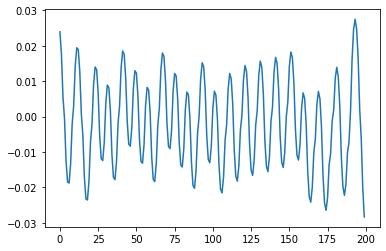

In [ ]:
plt.plot(arrEpisode, arrAngle)
#plt.plot(arrEpisode, arr1)

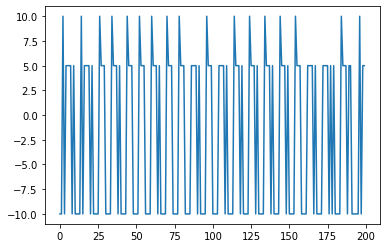

In [ ]:
plt.plot(arrEpisode, arr1)

# Don't Go Below

In [ ]:
import gym
import numpy as np
import random
import math
from time import sleep

# Initialize the "Cart-Pole" environment
env = gym.make('CartPole-v0')

# Defining the environment related constants
NUM_STATE = 10
NUM_ACTION = env.action_space.n
ANGLE_STATE_INDEX = 2
ANGLE_BOUND = (-env.theta_threshold_radians*1.2, env.theta_threshold_radians*1.2)
MIN_EXPLORE_RATE = 0.1
MIN_LEARNING_RATE = 0.1

# Defining the simulation related constants
NUM_EPISODES = 400
MAX_T = 500
DEBUG_MODE = True
ENABLE_UPLOAD = False

# Creating a Q-Table for each action and state pair
q_table = np.zeros((NUM_STATE, NUM_ACTION))

# Manually inputting the preferred Q-values
for state_row in range(len(q_table)):
    if state_row  <= len(q_table)/2:
        q_table[state_row][0] = 1
    else:
        q_table[state_row][1] = 1

arrAngle = []
arrEpisode = []

def simulate():

    for episode in range(NUM_EPISODES):
        # Reset the environment
        obv = env.reset()

        # the initial state
        state_0 = angle_to_bucket(obv[ANGLE_STATE_INDEX])
        t_done = 0

        for t in range(MAX_T):
            # env.render()

            # Select an action
            action = select_action(state_0, 0)

            # Execute the action
            obv, reward, done, info = env.step(action)

            # Observe the result
            angle = obv[ANGLE_STATE_INDEX]
            state = angle_to_bucket(angle)

            # Setting up for the next iteration
            state_0 = state
            if not done:
                t_done = t

            # Print data
            # if (DEBUG_MODE):
            #     # print("\nEpisode = %d" % episode)
            #     # print("t = %d" % t)
            #     # print("Action: %d" % action)
            #print("Angle: %f" % angle)
            arrAngle.append(angle)
            arrEpisode.append(episode)
            #     # print("State: %d" % state)
            #     # print("Reward: %f" % reward)
            #     # print("Q Table")
            q_table_t = np.transpose(q_table)
            #     # for col in q_table_t:
            #     #     for q in col:
            #     #         print("%.2f" % q, end="  ")
            #     #     #print("")

            if angle < -env.theta_threshold_radians*2 or angle > env.theta_threshold_radians*2 :
               #print("Episode %d finished after %f time steps" % (episode, t_done))
               break

            #sleep(0.25)


def select_action(state, explore_rate):
    # Select a random action
    if random.random() < explore_rate:
        action = env.action_space.sample()
    # Select the action with the highest q
    else:
        action = np.argmax(q_table[state,:])
    return action


def get_explore_rate(t):
    return min(1, MIN_EXPLORE_RATE*NUM_EPISODES/(t+1))

def get_learning_rate(t):
    return min(0.8, MIN_LEARNING_RATE*NUM_EPISODES/(t+1))


def angle_to_bucket(angle):
    angle = min(ANGLE_BOUND[1], max(ANGLE_BOUND[0], angle))
    return int((angle - ANGLE_BOUND[0])/(ANGLE_BOUND[1] - ANGLE_BOUND[0])*(NUM_STATE-1))


def bucket_to_angle(state):

    return state / (NUM_STATE-1) * (ANGLE_BOUND[1] - ANGLE_BOUND[0]) + ANGLE_BOUND[0]


if __name__ == "__main__":
    simulate()

In [ ]:
import matplotlib.pyplot as plt
plt.plot(arrEpisode, arrAngle)